In [3]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct, idct
import pywt
from math import log10, sqrt 
import cv2 
import numpy as np 
from skimage.metrics import structural_similarity as SSIM
import os

In [4]:
def load_images(base_folder):
    images = []
    
    for subdir, dirs, files in os.walk(base_folder):
        for file in files:
            if file.lower().endswith((".tiff")):
                try:
                    file_path = os.path.join(subdir, file)
                    img = imread(file_path)
                    if img.ndim == 2:
                        img = img[:, :, np.newaxis]
                    images.append(img)
                except IOError:
                    print(f"Nie można załadować obrazu: {file_path}")
    return images
    

(256, 256, 3)


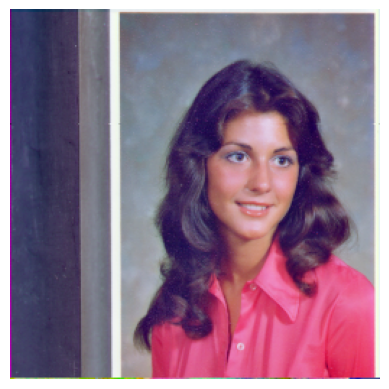

In [5]:
images = load_images('./data')

img = images[1]

plt.figure()
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [6]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0): 
        return 100
    
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    
    return psnr 

In [30]:
def fft_compression(img, threshold):
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        compressed_channels = []
        for i in range(3):
            channel_dct = np.fft.fft2(img[:, :, i])
            channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

            # Ensure the index is within bounds
            index = int(np.floor((1 - threshold) * len(channel_sort)))
            index = np.clip(index, 0, len(channel_sort) - 1)
            thresh = channel_sort[index]
            
            ind = np.abs(channel_dct) > thresh
            channel_compressed = channel_dct * ind
            channel_reconstructed = np.fft.ifft2(channel_compressed).real
            compressed_channels.append(channel_reconstructed)
        compressed_image = np.stack(compressed_channels, axis=-1)
    else:  # Grayscale image
        channel_dct = np.fft.fft2(img)
        channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

        # Ensure the index is within bounds
        index = int(np.floor((1 - threshold) * len(channel_sort)))
        index = np.clip(index, 0, len(channel_sort) - 1)
        thresh = channel_sort[index]
        
        ind = np.abs(channel_dct) > thresh
        channel_compressed = channel_dct * ind
        compressed_image = np.fft.ifft2(channel_compressed).real

    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)
    return compressed_image


In [28]:
def wavelet_compression(img, threshold=0.1):
    compressed_channels = []
    n = 4  # Level of wavelet decomposition
    wavelet_function = 'db1'  # Daubechies wavelet with one vanishing moment
    
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    
    if img.ndim == 3 and img.shape[2] == 3:  # RGB image
        for i in range(3):  # Process each channel individually
            coeffs = pywt.wavedec2(img[:, :, i], wavelet=wavelet_function, level=n, axes=(0, 1))
            coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs, axes=(0, 1))
            Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

            # Ensure the index is within bounds
            index = int(np.floor((1 - threshold) * len(Csort)))
            index = np.clip(index, 0, len(Csort) - 1)
            thresh = Csort[index]
            
            ind = np.abs(coeff_arr) > thresh
            Cfilt = coeff_arr * ind

            coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
            channel_reconstructed = pywt.waverec2(coeffs_filt, wavelet=wavelet_function, axes=(0, 1))
            compressed_channels.append(channel_reconstructed)
        compressed_image = np.stack(compressed_channels, axis=-1)

    else:  # Assuming Grayscale image
        coeffs = pywt.wavedec2(img, wavelet=wavelet_function, level=n, axes=(0, 1))
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs, axes=(0, 1))
        Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

        # Ensure the index is within bounds
        index = int(np.floor((1 - threshold) * len(Csort)))
        index = np.clip(index, 0, len(Csort) - 1)
        thresh = Csort[index]
        
        ind = np.abs(coeff_arr) > thresh
        Cfilt = coeff_arr * ind

        coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
        compressed_image = pywt.waverec2(coeffs_filt, wavelet=wavelet_function, axes=(0, 1))
        compressed_channels.append(compressed_image)

    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)  # Ensure pixel values are valid
    if compressed_image.ndim == 2:
        compressed_image = np.expand_dims(compressed_image, axis=2)

    return compressed_image


In [22]:
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def dct_compression(img, threshold=0.1):
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        compressed_channels = []
        for i in range(3):
            channel_dct = dct2(img[:, :, i])
            channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

            # Ensure the index is within bounds
            index = int(np.floor((1 - threshold) * len(channel_sort)))
            index = np.clip(index, 0, len(channel_sort) - 1)  
            thresh = channel_sort[index]
            
            ind = np.abs(channel_dct) > thresh
            channel_compressed = channel_dct * ind
            channel_reconstructed = idct2(channel_compressed).real

            compressed_channels.append(channel_reconstructed)
        compressed_image = np.stack(compressed_channels, axis=-1)
    else: 
        channel_dct = dct2(img)
        channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

        # Ensure the index is within bounds
        index = int(np.floor((1 - threshold) * len(channel_sort)))
        index = np.clip(index, 0, len(channel_sort) - 1)  
        thresh = channel_sort[index]

        ind = np.abs(channel_dct) > thresh
        channel_compressed = channel_dct * ind
        compressed_image = idct2(channel_compressed).real

    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)
    if compressed_image.ndim == 2:
        compressed_image = np.expand_dims(compressed_image, axis=2)
    
    return compressed_image


1. Transformacja Fouriera: Najpierw, obraz jest przekształcany z dziedziny przestrzennej (czyli normalnego obrazu) do dziedziny częstotliwości za pomocą Transformacji Fouriera. Wynikową macierz nazywamy spektrum Fouriera, a jej elementy to współczynniki Fouriera, które zawierają informacje o amplitudzie i fazie różnych częstotliwości w obrazie.

2. Sortowanie Współczynników: Współczynniki Fouriera są sortowane według ich wartości bezwzględnych. Wartość bezwzględna tych współczynników odzwierciedla "ważność" lub "siłę" danej częstotliwości w reprezentacji obrazu.

3. Ustalenie Progu: Wartość progu jest ustalana na podstawie zadanej wartości threshold, która jest procentem (lub frakcją) współczynników, które chcemy zachować. Na przykład, jeśli threshold wynosi 0.1, to znaczy, że chcemy zachować 10% najważniejszych (największych) współczynników. Progowe ucięcie współczynników jest realizowane poprzez obliczenie indeksu, który odpowiada 90% (czyli 1 minus threshold) wszystkich posortowanych współczynników. Wartość współczynnika na tym indeksie staje się naszym progiem.

4. Maskowanie Współczynników: Tworzona jest maska binarna, która identyfikuje, które współczynniki są większe niż ustalony próg. Tylko współczynniki, które przekraczają ten próg, są zachowywane, a reszta jest zerowana.

5. Rekonstrukcja Obrazu: Po nałożeniu maski, zachowane współczynniki są używane do odwrotnej Transformacji Fouriera, aby przekształcić obraz z powrotem do dziedziny przestrzennej.

In [15]:
import random

def simulated_annealing_for_compression(img, compression_function ,target_psnr=30, max_iter=1000, initial_temp=100, cooling_rate=0.99):
    threshold = 0.1
    best_threshold = threshold
    best_psnr = 0
    current_temp = initial_temp

    for iteration in range(max_iter):
        compressed_image = compression_function(img, threshold)
        current_psnr = PSNR(img, compressed_image)
        
        if abs(current_psnr - target_psnr) < abs(best_psnr - target_psnr):
            best_psnr = current_psnr
            best_threshold = threshold

        if abs(current_psnr - target_psnr) < 1:
            break
        
        new_threshold = threshold + (random.random() - 0.5) * 0.2  # Randomly adjust the threshold
        new_threshold = np.clip(new_threshold, 0, 1)  # Ensure the threshold stays within [0, 1]

        compressed_image_new = compression_function(img, new_threshold)
        new_psnr = PSNR(img, compressed_image_new)
        
        if acceptance_probability(current_psnr, new_psnr, current_temp) > random.random():
            threshold = new_threshold
        
        current_temp *= cooling_rate  # Decrease the temperature

    print(f'Final PSNR: {best_psnr}, Final Threshold: {best_threshold}')
    return compression_function(img, best_threshold)

def acceptance_probability(current_psnr, new_psnr, temperature):
    if new_psnr > current_psnr:
        return 1.0
    return np.exp((new_psnr - current_psnr) / temperature)

In [11]:
def SSIM_RGB(img1, img2):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")
    
    if len(img1.shape) == 3 and img1.shape[2] == 1:
        img1 = img1[:, :, 0]
        img2 = img2[:, :, 0]
        return SSIM(img1, img2, data_range=img1.max() - img1.min())

    elif len(img1.shape) == 3 and img1.shape[2] == 3:  # RGB images
        ssim_sum = 0.0
        for i in range(3):
            ssim_sum += SSIM(img1[:, :, i], img2[:, :, i], multichannel=True, data_range=255)
        return ssim_sum / 3.0

    elif len(img1.shape) == 2:
        return SSIM(img1, img2, data_range=img1.max() - img1.min())

    else:
        raise ValueError("Input images must have either 2 or 3 dimensions")


Final PSNR: 34.677391622230026, Final Threshold: 0.05355915121959387
34.677391622230026


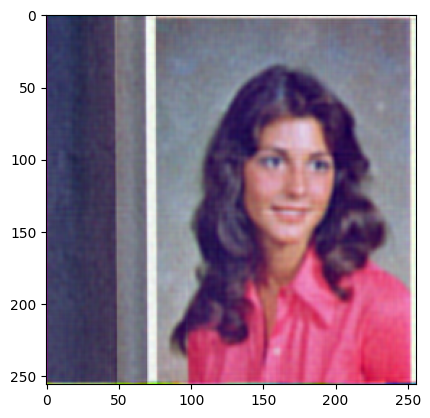

In [36]:
compressed_img_sim = simulated_annealing_for_compression(img,dct_compression ,35, 1000, 1000, 0.9)
plt.imshow(compressed_img_sim.astype(np.uint8))
print(PSNR(img, compressed_img_sim))

Final PSNR: 35.56082427277858, Final Threshold: 0.1
35.560853608576195


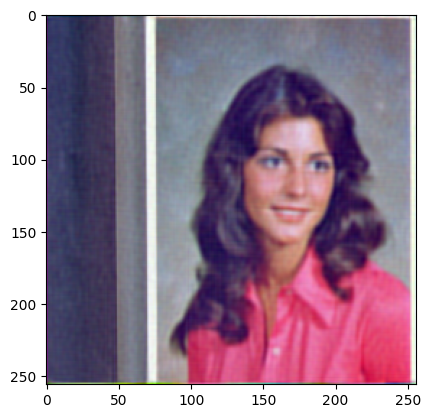

In [34]:
compressed_img_sim = simulated_annealing_for_compression(img,fft_compression ,35, 1000, 1000, 0.9)
plt.imshow(compressed_img_sim.astype(np.uint8))
print(PSNR(img, compressed_img_sim))

Final PSNR: 34.444657878490545, Final Threshold: 0.06379990939055297
34.444657878490545


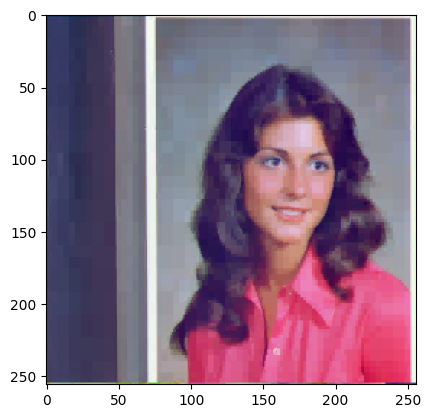

In [38]:
compressed_img_sim = simulated_annealing_for_compression(img,wavelet_compression,35, 1000, 1000, 0.9)
plt.imshow(compressed_img_sim.astype(np.uint8))
print(PSNR(img, compressed_img_sim))

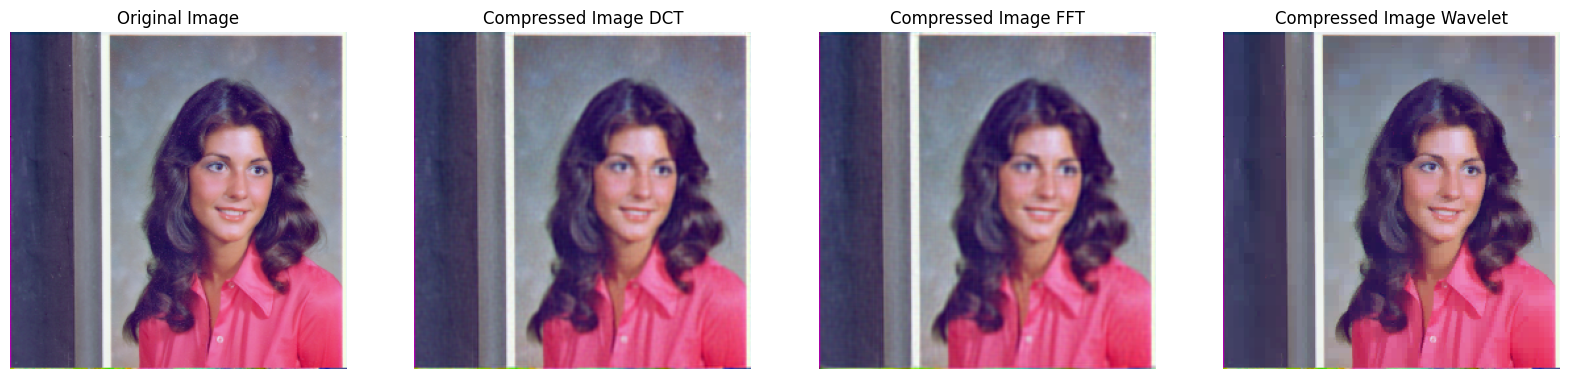

In [27]:
compressed_image_dct = dct_compression(img, threshold=0.1)
compressed_image_fft = fft_compression(img, threshold=0.1)
compressed_image_wavelet = wavelet_compression(img.squeeze(), threshold=0.1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(compressed_image_dct.astype(np.uint8))
plt.title('Compressed Image DCT')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(compressed_image_fft.astype(np.uint8))
plt.title('Compressed Image FFT')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(compressed_image_wavelet.astype(np.uint8))
plt.title('Compressed Image Wavelet')
plt.axis('off')
plt.show()

In [45]:
print('PSNR Wavelets:', PSNR(img, compressed_image_wavelet))
print('PSNR fft:', PSNR(img, compressed_image_fft))
print('PSNR dct:', PSNR(img, compressed_image_dct))

PSNR Wavelets: 36.28818860236067
PSNR fft: 32.917690965201686
PSNR dct: 36.56427509755538


In [46]:
print('SSIM Wavelets:', SSIM_RGB(img, compressed_image_wavelet))
print('SSIM fft:', SSIM_RGB(img, compressed_image_fft))
print('SSIM dct:', SSIM_RGB(img, compressed_image_dct))

SSIM Wavelets: 0.9176642072908665
SSIM fft: 0.8257886309501293
SSIM dct: 0.9253920874047528


In [47]:
def average_ssim(list_images1, list_images2):
    if len(list_images1) != len(list_images2):
        raise ValueError("Both lists must contain the same number of images.")
    
    total_ssim = 0.0
    num_images = len(list_images1)
    
    for img1, img2 in zip(list_images1, list_images2):
        if img1.shape != img2.shape:
            print(img1.shape, img2.shape)
            raise ValueError("All images in the pairs must have the same dimensions.")
        
        current_ssim = SSIM_RGB(img1, img2)
        total_ssim += current_ssim
    
    return total_ssim / num_images

In [48]:
def average_pnsr(list_images1, list_images2):
    if len(list_images1) != len(list_images2):
        raise ValueError("Both lists must contain the same number of images.")
    
    total_psnr = 0.0
    num_images = len(list_images1)
    
    for img1, img2 in zip(list_images1, list_images2):
        if img1.shape != img2.shape:
            raise ValueError("All images in the pairs must have the same dimensions.")
        
        current_psnr = PSNR(img1, img2)
        total_psnr += current_psnr
    
    return total_psnr / num_images

In [49]:
compressed_images_dct = [dct_compression(img) for img in images]

avg_ssim_dct = average_ssim(images, compressed_images_dct)
avg_pnsr_dct = average_pnsr(images, compressed_images_dct)

KeyboardInterrupt: 

In [ ]:
compressed_images_fft = [fft_compression(img) for img in images]

avg_ssim_fft = average_ssim(images, compressed_images_fft)
avg_pnsr_fft = average_pnsr(images, compressed_images_fft)

In [ ]:
compressed_images_wavelets = [wavelet_compression(img) for img in images]

avg_ssim_wavelets = average_ssim(images, compressed_images_wavelets)
avg_pnsr_wavelets = average_pnsr(images, compressed_images_wavelets)

In [ ]:
print(f'Średni SSIM dla DCT= {avg_ssim_dct}, Średni PNSR dla DCT= {avg_pnsr_dct}')
print(f'Średni SSIM dla FFT= {avg_ssim_fft}, Średni PNSR dla DCT= {avg_pnsr_fft}')
print(f'Średni SSIM dla Wavelets= {avg_ssim_wavelets}, Średni PNSR dla Wavelets= {avg_pnsr_wavelets}')

Średni SSIM dla DCT= 0.7490029680035684, Średni PNSR dla DCT= 32.1508301541331
Średni SSIM dla FFT= 0.751958755404942, Średni PNSR dla DCT= 32.144818249256545
Średni SSIM dla Wavelets= 0.845550007629806, Średni PNSR dla Wavelets= 34.85281005001279
